In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import PIL
from PIL import Image

In [2]:
print("PyTorch version:", torch.__version__)
print("Is GPU available?", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
print("Name of the GPU available:", torch.cuda.get_device_name())

PyTorch version: 1.11.0
Is GPU available? True
Number of GPUs available: 1
Name of the GPU available: NVIDIA GeForce GTX 1650 Ti


In [3]:
parent_data_path = "../Datasets/CelebA_Dataset/img_align_celeba/img_align_celeba"
list_images = os.listdir(parent_data_path)
num_images = len(list_images)

Resolution of Image: (178, 218)


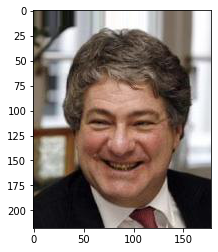

In [10]:
# A preivew of a random image in the dataset
random_index = np.random.randint(low=0, high=num_images+1)
random_image_path = parent_data_path + "/" + list_images[random_index]
rand_image = plt.imread(random_image_path)
plt.imshow(rand_image);
rand_image_pil = Image.open(random_image_path)
print("Resolution of Image:", rand_image_pil.size)


#### It is important to note that we will resize our images to 64 x 64 for decreasing the training time

Things to keep in mind:
* Normalize input images to [-1, 1]
* Try using dropout layers
* Sample noise vector from normal/gaussian distribution instead of uniform distribution
* Construct different mini-batches for real and fake, i.e. each mini-batch needs to contain only all real images or all generated images.
* Use ADAM optimizer
* If Discriminator loss goes to 0: failure mode
* Check norms of gradients: if they are over 100 things are screwing up

In [5]:
#### From PyTorch docs
# Note that the module itself is callable, and that calling it invokes its forward() function. 
# This name is in reference to the concepts of “forward pass” and “backward pass”, which apply to
# each module

In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # First layer of the discriminator will be given an input of shape: batch_size x img_channeles x 64 x 64
            nn.Conv2d(
                img_channels, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # Second layer of the discriminator will get input of shape: batch_size x features_d x 32 x 32
            self._disc_block(features_d, features_d*2, 4, 2, 1),
            # Third layer of the discriminator will get input of shape: batch_size x features_d*2 x 16 x 16
            self._disc_block(features_d*2, features_d*4, 4, 2, 1),
            # Fourth layer of the discriminator will get input of shape: batch_size x features_d*4 x 8 x 8
            self._disc_block(features_d*4, features_d*8, 4, 2, 1),
            # Fifth layer of the discriminator will get input of shape: batch_size x features_d*8 x 4 x 4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding = 0),
            # Fifth layer will give an output of shape: batch_size x 1 x 1 x 1
            nn.Sigmoid()
        )
    
    def _disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(
                out_channels
            ),
            nn.LeakyReLU(0.2)
        )
        return block 
    
    def forward(self, x):
        return self.disc(x)

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # First layer of the generator will be given an input of shape: batch_size x z_dim x 1 x 1
            self._gen_block(z_dim, features_g*16, 4, 2, 0),
            # Second layer of the generator will be given an input of shape: batch_size x features_g*16 x 4 x 4
            self._gen_block(features_g*16, features_g*8, 4, 2, 1),
            # Third layer of the generator will be given an input of shape: batch_size x features_g*8 x 8 x 8
            self._gen_block(features_g*8, features_g*4, 4, 2, 1),
            # Fourth layer of the generator will be given an input of shape: batch_size x features_g*4 x 16 x 16
            self._gen_block(features_g*4, features_g*2, 4, 2, 1),
            # Fifth layer of the generator will be given an input of shape: batch_size x features_g*2 x 32 x 32
            nn.ConvTranspose2d(features_g*2, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def _gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias = False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
        return block

    def forward(self, x):
        return self.gen(x)

In [13]:
# Try not initializing weights to see change in performance
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    # We will intialize the weights for all the trainable layers according to the guidance in the paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Training Process for the DCGAN

In [14]:
import torchvision
import torchvision.datasets as datasets
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [15]:
# Hyperparameters for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0003
BATCH_SIZE = 128
H, W = 64, 64
IMG_CHANNELS = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_D = 64
FEATURES_G = 64

In [16]:
torch.manual_seed(17)
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]
    )
])

In [17]:
os.listdir("../")

['.ipynb_checkpoints', 'Datasets', 'DCGAN_From_Scratch', 'GAN_From_Scratch']

In [19]:
saved_model = False
path = "../DCGAN_From_Scratch"
for file in os.listdir(path):
    if file == "generator_model":
        saved_model = True

        
if saved_model == False:
    dataset = datasets.MNIST(root="../Datasets", train=True, transform=transform, download=True);
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G).to(device)
    disc = Discriminator(IMG_CHANNELS, FEATURES_D).to(device)
    initialize_weights(gen)
    initialize_weights(disc)

    opt_gen = Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_disc = Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

    criterion = nn.BCELoss()
    fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

    writer_real = SummaryWriter(f"logs/real")
    writer_fake = SummaryWriter(f"logs/fake")
    step = 0

    gen.train()
    disc.train()

    for epoch in range(NUM_EPOCHS):
        print("In epoch", epoch)
        for batch_idx, (real, _) in enumerate(dataloader):
            real = real.to(device)
            noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
            fake = gen(noise)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc_real = disc(real).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake.detach()).reshape(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = disc(fake).reshape(-1)
            loss_gen = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

            # Print losses occasionally and print to tensorboard
            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                      Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
                )

                with torch.no_grad():
                    fake = gen(fixed_noise)
                    # take out (up to) 32 examples
                    img_grid_real = torchvision.utils.make_grid(
                        real[:32], normalize=True
                    )
                    img_grid_fake = torchvision.utils.make_grid(
                        fake[:32], normalize=True
                    )

                    writer_real.add_image("Real", img_grid_real, global_step=step)
                    writer_fake.add_image("Fake", img_grid_fake, global_step=step)

                step += 1

else:
    gen = torch.load(path + "/generator_model")

In [25]:
gen = Generator(Z_DIM, IMG_CHANNELS, FEATURES_G)
gen.load_state_dict(torch.load(path + "/generator_model"))

<All keys matched successfully>

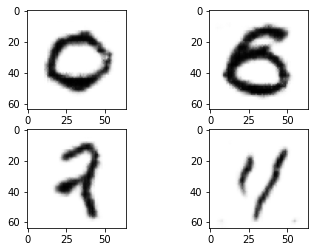

In [61]:
num_images = 4
# Check if these number of images can be displayed in an 2^a x 2^b grid format
assert num_images%2==0 and num_images != 0

noise = torch.randn(num_images, Z_DIM, 1, 1)
output_np = gen(noise).detach().numpy()

for num in range(num_images):
    plt.subplot(num_images//2, num_images//2, num+1)
    plt.imshow(output_np[num][0], cmap='binary')
